In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import erfc

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from file_handler import HistoryHandler
from functions import compute_RE, get_timing_info
from Paper.figure_scripts import common

In [8]:
import matplotlib.pyplot as plt
incr = 5
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath, amsfonts, amssymb}",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 20 + incr,
    "font.size": 20 + incr,
    "legend.fontsize": 16 + incr,
    "xtick.labelsize": 20 + incr, #18
    "ytick.labelsize": 20 + incr,
})

In [9]:
def avg_bound(max_grad, sigma, r=0, mu=0):
    return 2 * max_grad * (1 - 0.5 * np.exp(sigma**2) *
                           (np.exp(-mu) * erfc(sigma - mu / (2 * sigma)) +
                            np.exp(mu) * erfc(sigma + mu / (2 * sigma)))) / (1 - r)

def kl_bound(max_grad, sigma, r=0, mu=0):
    return sigma * max_grad 

def min_bound(max_grad, sigma, r=0, mu=0):
    return np.minimum(avg_bound(max_grad, sigma, r, mu), kl_bound(max_grad, sigma, r, mu))

In [10]:
L = 10
arch = f"ResCNN_nblocks4_nfilters16_KernelShape3x3"
n_dim = 2
PBC = True
dtype_labels = [None, "f32", "f16", "bf16"]
model_label = "TFIM"
hs = np.array([1, 3.04438, 5])
model_params = [{"J": 1, "h": h} for h in hs]
dmrg = False

n_samples=2**12
n_chains=2**10

folder = f"{PROJECT_ROOT}Data/History/"

In [11]:
loss_functions = [[None for _ in dtype_labels] for _ in hs]
variance = [[None for _ in dtype_labels] for _ in hs]
total_time = [[None for _ in dtype_labels] for _ in hs]
energy = [[None for _ in dtype_labels] for _ in hs]
re = [[None for _ in dtype_labels] for _ in hs]
timinig_info = [[None for _ in dtype_labels] for _ in hs]
sigma = [[None for _ in dtype_labels] for _ in hs]
gradient_noise = [[None for _ in dtype_labels] for _ in hs]
gradient_max = [None for _ in hs]

for h in range(len(hs)):
    for d in range(len(dtype_labels)):
        if dtype_labels[d] is not None:
                _folder = f"LPS/{dtype_labels[d]}/"
        else:
            _folder = "" 
        name = f"{folder}{_folder}MC/"
        hh = HistoryHandler(name, model_label, arch, L, PBC, n_dim, **model_params[h], n_samples=n_samples, n_chains=n_chains)
        df = hh.load_history()

        loss_functions[h][d] = df["Mean"].to_numpy()
        variance[h][d] = df["Variance"].to_numpy()
        total_time[h][d] = df["total_time"].to_numpy()[0]
        energy[h][d] = df["Mean"].to_numpy()
        sigma[h][d] = df['sigma'].to_numpy()
        if d == 0:
            gradient_noise[h] = df['gradient_noise'].to_numpy()
            gradient_max[h] = df['gradient_max'].to_numpy()
        timinig_info[h][d] = get_timing_info(hh.history_file)

dtype_labels[0] = "f64"

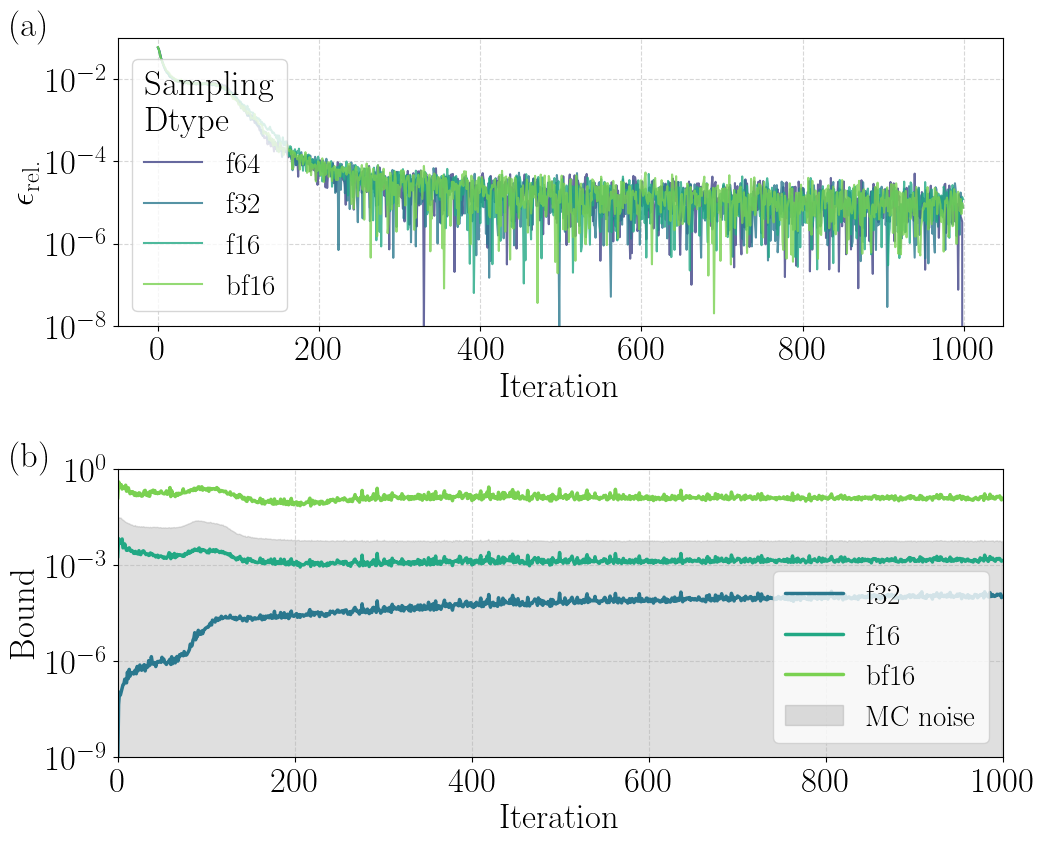

In [12]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig, axes = plt.subplots(2, 1, figsize=(11, 9))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(dtype_labels)))

letter_x = -0.12
letter_y = 1.01

ax_loss = axes[0]
h = 1

for d in range(len(dtype_labels)):
    x = np.arange(len(loss_functions[h][d]))
    y = np.abs(loss_functions[h][d] - loss_functions[h][0][-1]) / np.abs(loss_functions[h][0][-1])
    ax_loss.plot(
        x, y,
        color=colors[d],
        label=dtype_labels[d],
        alpha=0.8
    )

ax_loss.set_xlabel("Iteration")
ax_loss.set_ylabel(r"$\epsilon_{\text{rel.}}$")
ax_loss.set_yscale("log")
ax_loss.set_ylim(1e-8, 1e-1)
ax_loss.grid(True, linestyle="--", alpha=0.5)
ax_loss.text(letter_x, letter_y, "(a)", transform=ax_loss.transAxes, fontweight="bold")

ax_loss.legend(
    title="Sampling\nDtype",
    loc="lower left",
    frameon=True
)

ax_bound = axes[1]

dtype_labels_plot = ['f32', 'f16', 'bf16']
dtype_indices = [1, 2, 3]

for d_idx, d in enumerate(dtype_indices):
    bound_data = min_bound(
        np.asarray(gradient_max[h]),
        np.asarray(sigma[h][d])
    )

    x = np.arange(len(bound_data))
    ax_bound.plot(
        x,
        bound_data,
        color=colors[d],
        lw=2.5,
        label=dtype_labels_plot[d_idx],
        dash_capstyle='round',
        solid_capstyle='round'
    )

noise_data = gradient_noise[h] * np.sqrt(2) * 3
x_noise = np.linspace(0, len(bound_data) - 1, len(noise_data))
noise_interp = np.interp(x, x_noise, noise_data)

ax_bound.fill_between(
    x,
    0,
    noise_interp,
    color="gray",
    alpha=0.25,
    label="MC noise"
)

ax_bound.set_xlabel("Iteration")
ax_bound.set_yscale("log")
ax_bound.set_ylabel("Bound")
ax_bound.set_xlim(0, len(bound_data))
ax_bound.set_ylim(1e-9, 1)
ax_bound.grid(True, ls="--", alpha=0.5)
ax_bound.text(letter_x, letter_y, "(b)", transform=ax_bound.transAxes, fontweight="bold")

ax_bound.legend(loc="lower right")

plt.tight_layout()
plt.savefig("figures/loss_and_noise.pdf")
plt.show()